# Banking Project

***

>The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

>To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

> _ - in Banking Case Description, ECAC Moodle Page_

***

[Kaggle Challenge Page](https://www.kaggle.com/)

The steps performed are as follows:
* Data Loading and Cleaning
* Descriptive Data Mining & Feature Engineering
* Predictive Data Mining

## Tools

For this work we will use the common tools in a data scientist and engineer arsenal. All of them work together in a seamless fashion, as well as with the Jupyter Notebook (this enhanced interactive document).

* **Numpy** is the fundamental package for scientific computing with Python
* **Pandas** provides high-performance, easy-to-use data structures (_e.g._ data frames) and data analysis tools
* **Matplotlib** implements plotting functionality
* **Scikit Learn** aggregates advanced machine learning tools

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn

plt.style.use('ggplot')
%matplotlib inline

## 1. Data Loading and Cleaning

A key initial step in every data mining work is to clean the data. This reduces the occurence of future unexpected behaviors and gives a preliminary insight over the "raw" data.

The **transactions** records describe transactions on accounts, representing dynamic characteristics of the accounts.

In [2]:
transactions_df = pd.read_csv('./data/banking - transaction.csv', 
                              sep=';',
                              parse_dates=['date'],
                              infer_datetime_format=True,
                              dtype={'bank':np.str},
                              index_col='trans_id')

In [3]:
transactions_df.head()

,account_id,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,
695247,2378,1993-01-01,credit,credit in cash,700,700,NaN,NaN,NaN
171812,576,1993-01-01,credit,credit in cash,900,900,NaN,NaN,NaN
207264,704,1993-01-01,credit,credit in cash,1000,1000,NaN,NaN,NaN
1117247,3818,1993-01-01,credit,credit in cash,600,600,NaN,NaN,NaN
579373,1972,1993-01-02,credit,credit in cash,400,400,NaN,NaN,NaN


**k_symbol** name is not very represent representative.

In [4]:
transactions_df = transactions_df.rename(columns={
    'k_symbol': 'trans_char'
    })

In [5]:
transactions_df.head()

,account_id,date,type,operation,amount,balance,trans_char,bank,account
trans_id,,,,,,,,,
695247,2378,1993-01-01,credit,credit in cash,700,700,NaN,NaN,NaN
171812,576,1993-01-01,credit,credit in cash,900,900,NaN,NaN,NaN
207264,704,1993-01-01,credit,credit in cash,1000,1000,NaN,NaN,NaN
1117247,3818,1993-01-01,credit,credit in cash,600,600,NaN,NaN,NaN
579373,1972,1993-01-02,credit,credit in cash,400,400,NaN,NaN,NaN


The **accounts** records contain static characteristics of the accounts.

In [6]:
accounts_df = pd.read_excel('./data/banking.xlsx', 
                            sheetname='account',
                            parse_dates=['date'],
                            infer_datetime_format=True,
                            index_col='account_id'
                           )

In [7]:
accounts_df.head()

,district_id,frequency,date
account_id,,,
576,55,monthly issuance,1993-01-01
3818,74,monthly issuance,1993-01-01
704,55,monthly issuance,1993-01-01
2378,16,monthly issuance,1993-01-01
2632,24,monthly issuance,1993-01-02


The **clients** records describe static characteristics of the clients.

In [8]:
clients_df = pd.read_excel('./data/banking.xlsx',
                           sheetname='client',
                           index_col='client_id')

In [9]:
clients_df.head()

,birth_number,district_id
client_id,,
1,706213,18
2,450204,1
3,406009,1
4,561201,5
5,605703,5


The **birth_number** feature is not readable in this representation. We have, then, to parse it and transform it into two new columns: **birthday** and **gender**.

In [10]:
clients_df['gender'] = clients_df.apply(lambda c: 'Male' if c['birth_number'] % 10000 < 5000 else 'Female', axis=1)

In [11]:
from datetime import date

def normalize_birth_number(client):
    birth_number = int(client['birth_number'])
    year = birth_number // 10000
    month = (birth_number // 100) % 100
    day = birth_number % 100
    
    month = month if month < 50 else month - 50
    
    return  "{0:02d}{1:02d}{2:02d}".format(year, month, day)


clients_df['birth_number'] = clients_df.apply(normalize_birth_number, axis=1) # month - 50 on females
clients_df['birthday'] = pd.to_datetime(clients_df['birth_number'], format='%y%m%d')
clients_df['birthday'] = clients_df.apply(
    lambda c: c['birthday'] if c['birthday'].date() <= date.today() else (c['birthday'] - pd.tseries.offsets.DateOffset(years=100)), 
    axis=1) # if infered year > 2015 the it is in the 19's
clients_df = clients_df.drop('birth_number', axis=1)

In [12]:
clients_df.head()

,district_id,gender,birthday
client_id,,,
1,18,Female,1970-12-13
2,1,Male,1945-02-04
3,1,Female,1940-10-09
4,5,Male,1956-12-01
5,5,Female,1960-07-03


The **dispositions** records relate a client with an account (being useful in join operations).

In [13]:
dispositions_df = pd.read_excel('./data/banking.xlsx',
                                sheetname='disposition',
                                index_col='disp_id')

In [14]:
dispositions_df.head()

,client_id,account_id,type
disp_id,,,
1,1,1,OWNER
2,2,2,OWNER
3,3,2,DISPONENT
4,4,3,OWNER
5,5,3,DISPONENT


The **payment_orders** records, like **transaction** records, represent another dynamic characteristic of accounts.

In [15]:
payment_orders_df = pd.read_excel('./data/banking.xlsx',
                                  sheetname='payment order',
                                  index_col='order_id')

In [16]:
payment_orders_df.head()

,account_id,bank_to,account_to,amount,k_symbol
order_id,,,,,
29401,1,YZ,87144583,2452.0,household
29402,2,ST,89597016,3372.7,loan
29403,2,QR,13943797,7266.0,household
29404,3,WX,83084338,1135.0,household
29405,3,CD,24485939,327.0,NaN


The **loans** records describe information of a loan for an account.

In [17]:
loans_df = pd.read_excel('./data/banking.xlsx',
                         sheetname='loan',
                         parse_dates=['date'],
                         infer_datetime_format=True,
                         index_col='loan_id')

In [18]:
loans_df.head()

,account_id,date,amount,duration,payments,status
loan_id,,,,,,
5314,1787,1993-07-05,96396,12,8033,B
5316,1801,1993-07-11,165960,36,4610,A
6863,9188,1993-07-28,127080,60,2118,A
5325,1843,1993-08-03,105804,36,2939,A
7240,11013,1993-09-06,274740,60,4579,A


The **credit_cards** records describes static information of a credit card.

In [19]:
credit_cards_df = pd.read_excel('./data/banking.xlsx',
                                sheetname='credit card',
                                parse_dates=['issued'],
                                infer_datetime_format=True,
                                index_col='card_id')

In [20]:
credit_cards_df.head()

,disp_id,type,issued
card_id,,,
1005,9285,classic,1993-11-07
104,588,classic,1994-01-19
747,4915,classic,1994-02-05
70,439,classic,1994-02-08
577,3687,classic,1994-02-15


The **districts** records provide demographic information about a district.

In [21]:
districts_df = pd.read_excel('./data/banking.xlsx',
                             sheetname='district',
                             index_col='A1')

In [22]:
districts_df.head()

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
A1,,,,,,,,,,,,,,,
1,D1,R1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,D2,R2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
3,D3,R2,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
4,D4,R2,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
5,D5,R2,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


The column labels provided lack any useful information.

In [23]:
districts_df = districts_df.rename(columns={
        'A2': 'district_name',
        'A3': 'region',
        'A4': 'no_inhabitants',
        'A5': 'no_municipalities_w_inhabitants_<499',
        'A6': 'no_municipalities_w_inhabitants_500-1999',
        'A7': 'no_municipalities_w_inhabitants_2000-9999',
        'A8': 'no_municipalities_w_inhabitants_>10000',
        'A9': 'no_cities',
        'A10': 'ratio_urban_inhabitants',
        'A11': 'average_salary',
        'A12': 'unemployment_rate_95',
        'A13': 'unemployment_rate_96',
        'A14': 'no_enterpreneurs_per_1000_inhabitants',
        'A15': 'no_commited_crimes_95',
        'A16': 'no_commited_crimes_96',
    })

districts_df.index.name = 'district_id'

In [24]:
districts_df.head()

,district_name,region,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
district_id,,,,,,,,,,,,,,,
1,D1,R1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,D2,R2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
3,D3,R2,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
4,D4,R2,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
5,D5,R2,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


Lets check if the types infered by Pandas library are correct:

In [25]:
districts_df.dtypes

district_name                                 object
region                                        object
no_inhabitants                                 int64
no_municipalities_w_inhabitants_<499           int64
no_municipalities_w_inhabitants_500-1999       int64
no_municipalities_w_inhabitants_2000-9999      int64
no_municipalities_w_inhabitants_>10000         int64
no_cities                                      int64
ratio_urban_inhabitants                      float64
average_salary                                 int64
unemployment_rate_95                          object
unemployment_rate_96                         float64
no_enterpreneurs_per_1000_inhabitants          int64
no_commited_crimes_95                         object
no_commited_crimes_96                          int64
dtype: object

We see that **unemployment_rate_95** and **no_commited_crimes_95** are loaded as objects.

In [26]:
districts_df['unemployment_rate_95'].unique()

array(['0.29', '1.67', '1.95', '4.64', '3.85', '2.95', '2.26', '1.25',
       '3.39', '0.56', '0.45', '3.83', '2.77', '1.42', '3.13', '1.12',
       '2.38', '2.83', '2.65', '1.51', '1.10', '1.79', '1.39', '2.47',
       '2.64', '0.65', '1.62', '2.82', '3.38', '3.52', '2.80', '5.75',
       '6.43', '1.02', '3.33', '4.46', '7.08', '7.34', '6.49', '3.32',
       '2.41', '1.72', '2.79', '2.28', '1.78', '1.89', '4.83', '2.51',
       '2.52', '2.53', '1.60', '1.88', '4.69', '3.73', '3.24', '3.45',
       '4.76', '1.29', '3.79', '5.74', '3.51', '5.77', '4.09', '?', '6.63',
       '5.93', '3.80', '4.75', '5.38', '4.73', '4.01'], dtype=object)

In [27]:
districts_df['no_commited_crimes_95'].unique()

array([85677, 2159, 2824, 5244, 2616, 2640, 4289, 5179, 2987, 3810, 3475,
       3804, 1597, 6604, 1845, 1874, 1003, 1740, 999, 1563, 2299, 1089,
       2879, 5198, 1822, 6041, 1029, 1580, 818, 2985, 1328, 4340, 4650,
       5323, 3384, 5796, 4147, 2653, 4947, 6949, 6445, 1658, 4085, 2166,
       2080, 2854, 6079, 1655, 1660, 2123, 3496, 2564, 1850, 18721, 3659,
       3729, 2212, 2595, 1879, 2112, 2719, 1562, 4484, 2157, 2247, 3244,
       5623, '?', 9878, 4980, 9672, 4355, 18782, 4063, 3736, 3460], dtype=object)

We see that both use a question mark to demark missing values. We'll convert properly those columns:

In [28]:
districts_df['unemployment_rate_95'] = pd.to_numeric(districts_df['unemployment_rate_95'], errors='coerce')
districts_df['no_commited_crimes_95'] = pd.to_numeric(districts_df['no_commited_crimes_95'], errors='coerce')

districts_df.dtypes

district_name                                 object
region                                        object
no_inhabitants                                 int64
no_municipalities_w_inhabitants_<499           int64
no_municipalities_w_inhabitants_500-1999       int64
no_municipalities_w_inhabitants_2000-9999      int64
no_municipalities_w_inhabitants_>10000         int64
no_cities                                      int64
ratio_urban_inhabitants                      float64
average_salary                                 int64
unemployment_rate_95                         float64
unemployment_rate_96                         float64
no_enterpreneurs_per_1000_inhabitants          int64
no_commited_crimes_95                        float64
no_commited_crimes_96                          int64
dtype: object

## 2. Descriptive Data Mining & Feature Engineering

This first section aims at providing ways to better understand and extract value from the data. This is mostly accoplished by gathering descriptive statistics and ploting.

Considering this gathered knowledge, the datasets are edited and joined into useful intermediate format, which represent the main entities in the data, and then in a format in which the machine learning algorithms are able to understand (most of the times a single matrix, and most of the times without missing values).

The **loans** relate to the remainder entities through the **account** they are linked to. Therefore, the remainder entities should be summarized in such a way that each of the **accounts** information is given in a single row.

But before making any assumption, we should extract simple statistics about the feature space.

### Transactions Dataframe

In [29]:
transactions_df.describe(include='all')

,account_id,date,type,operation,amount,balance,trans_char,bank,account
count,1056320.000000,1056320,1056320,873206,1056320.000000,1056320.000000,574439,273508,295389.000000
unique,NaN,2191,3,5,NaN,NaN,8,13,NaN
top,NaN,1998-06-30 00:00:00,withdrawal,withdrawal in cash,NaN,NaN,interest credited,QR,NaN
freq,NaN,9269,634571,434918,NaN,NaN,183114,22285,NaN
first,NaN,1993-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,1998-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2936.867290,NaN,NaN,NaN,5924.145676,38518.330803,NaN,NaN,45670919.374916
std,2477.345127,NaN,NaN,NaN,9522.735373,22117.868013,NaN,NaN,30663396.851208
min,1.000000,NaN,NaN,NaN,0.000000,-41125.700000,NaN,NaN,0.000000
25%,1204.000000,NaN,NaN,NaN,135.900000,22402.500000,NaN,NaN,17828584.000000


**type**, **operation** and **trans_char** seem all to represent the same information. Lets evaluate that:

In [30]:
print("type:", transactions_df['type'].unique())

type: ['credit' 'withdrawal' 'withdrawal in cash']


In [31]:
print("operation:", transactions_df['operation'].unique())

operation: ['credit in cash' 'collection from another bank' 'withdrawal in cash' nan
 'remittance to another bank' 'credit card withdrawal']


In [32]:
print("trans_char:", transactions_df['trans_char'].unique())

trans_char: [nan 'pension' 'interest credited' 'household' 'statement' ' '
 'insurance payment' 'sanction for negative balance' 'loan payment']


**operation** seems irrelevant give **type**:

In [33]:
transactions_df_e = transactions_df.drop('operation', axis=1).copy() # 'e' for edited

Its also irrelevant the distinction between *withrawal* and *withrawal in cash*.

In [34]:
mask = transactions_df_e['type'] == 'withdrawal in cash'
transactions_df_e.ix[mask, 'type'] = ('withdrawal')

We will create an additional column to store the signed amount (given by the type of operation), and another with the normalized **signed_amount** value, according to the **balance** previous to the operation (if an operation is the first one, we store 0):

In [35]:
transactions_df_e['signed_amount'] = transactions_df_e.apply(lambda x: - x['amount'] if x['type'] == 'withdrawal' else x['amount'], axis=1)
transactions_df_e['norm_signed_amount'] = transactions_df_e.apply(lambda x: 
                                                                      0 if (x['balance'] - x['signed_amount']) == 0 
                                                                      else x['signed_amount'] / (x['balance'] - x['signed_amount']), 
                                                                  axis=1)

From **trans_char** we are able to extract if the user is pensionist, or if the user has been sanctioned for negative balance, among other things. We will create an additional table with that information, with the values weighted by the **amount**, indexed by **account_id**:

In [36]:
# select the needed rows from transactions_df
trans_temp_df = transactions_df_e[['account_id', 'trans_char', 'norm_signed_amount']].copy()

# remove the rows where an empty string is present
mask = trans_temp_df.trans_char != ' '
trans_temp_df = trans_temp_df.ix[mask]

# remove the rows containing NaN
trans_temp_df = trans_temp_df.dropna(axis='index')

In [37]:
# create the dataframe indexed by account_id
account_features_df = trans_temp_df[['account_id']].drop_duplicates(subset=['account_id'])
account_features_df = account_features_df.set_index('account_id')

# create the count columns, corresponding to the data countained in
    # pension
    # interest credited
    # household
    # statement
    # insurance payment
    # sanction for negative balance
    # loan payment

def create_trans_count_col(df, val):
    new_df = df.ix[df['trans_char'] == val].groupby('account_id').sum()
    new_df = new_df.rename(columns={'norm_signed_amount':val})
    return new_df

additional_dfs = [create_trans_count_col(trans_temp_df, val) for val in trans_temp_df['trans_char'].unique()]
account_features_df = account_features_df.join(additional_dfs)

account_features_df = account_features_df.fillna(0)

account_features_df.head()

,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment
account_id,,,,,,,
2177,25.253957,0.297190,-8.458351,-0.048057,0,0,0
1972,32.420419,0.296426,-7.261791,-0.046277,0,0,0
3592,32.100401,0.295263,-8.837104,-0.047720,0,0,0
576,26.308708,0.295281,-8.291333,-0.040056,0,0,0
2357,33.220426,0.294159,-11.231152,-0.041544,0,0,0


Now merge it with the **accounts** dataframe:

In [38]:
accounts_df = accounts_df.join(account_features_df)

# set to 0 the columns for accounts that do not have any transaction
accounts_df = accounts_df.fillna(0)

accounts_df.head()

,district_id,frequency,date,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment
account_id,,,,,,,,,,
576,55,monthly issuance,1993-01-01,26.308708,0.295281,-8.291333,-0.040056,0.000000,0,0
3818,74,monthly issuance,1993-01-01,0.000000,0.323475,-4.453223,-0.025151,-5.093869,0,0
704,55,monthly issuance,1993-01-01,0.000000,0.308940,-5.117044,-0.029023,0.000000,0,0
2378,16,monthly issuance,1993-01-01,0.000000,0.289776,-15.964195,-0.024958,0.000000,0,0
2632,24,monthly issuance,1993-01-02,0.000000,0.319428,-3.274818,-0.031207,-5.166912,0,0


Now we'll look into the **normalized signed amount** and **type** of each operation.

We will extract, for each **account**, the *count*, *mean* and *standard deviation* of operation values, as well as *mean* and *standard deviation* of the number of days between each **operation**, grouped by operation **type**.

In [39]:
temp_df = transactions_df_e[['account_id', 'type', 'norm_signed_amount', 'date']].copy()

# create columns with dates converted to days since 01-01-1970
#temp_df['date_days'] = temp_df.apply(lambda x: (x['date'] - pd.datetime(1970,1,1)).days, axis=1)

In [40]:
# sort firstly by account_id, then by date
temp_df = temp_df.sort_values(by=['account_id', 'date'])

#obtain, by row, the previous date
prev_dates = temp_df.groupby('account_id').apply(lambda x: x['date'].shift().fillna(x.iloc[0]['date'])).reset_index(level=0)
delta = temp_df['date'] - prev_dates['date']
delta = delta.astype("timedelta64[D]")
temp_df['date_delta'] = delta

In [41]:
#temp_df = temp_df.drop('date', axis='columns')

def summarize_transactions(df):
    summaries_dfs = []
    for tp in df['type'].unique():
        tmp_df = temp_df[temp_df['type'] == tp].drop('type', axis=1)
        
        tmp_grp_df = tmp_df.groupby('account_id').agg([np.count_nonzero, np.average, np.std])
        tmp_grp_df.fillna(0)
        
        ops_df = tmp_grp_df['norm_signed_amount']
        ops_df = ops_df.rename(columns={'count_nonzero': tp + '_cnt',
                                        'average': tp + '_avg',
                                        'std': tp + '_std',
                                       })
        
        dates_df = tmp_grp_df['date_delta']
        dates_df = dates_df.drop('count_nonzero', axis='columns')
        dates_df = dates_df.rename(columns={'average': tp + '_dates_avg',
                                            'std': tp + '_dates_std',
                                           })
        joined_summary_df = ops_df.join(dates_df)
        summaries_dfs.append(joined_summary_df)
    
    # now concatenate the summaries_dfs
    summaries_df = pd.concat(summaries_dfs, axis='columns')
    return summaries_df

trans_summaries_df = summarize_transactions(temp_df)
trans_summaries_df.head()

,credit_cnt,credit_avg,credit_std,credit_dates_avg,credit_dates_std,withdrawal_cnt,withdrawal_avg,withdrawal_std,withdrawal_dates_avg,withdrawal_dates_std
account_id,,,,,,,,,,
1,101,0.190443,0.451871,4.323529,4.607703,137,-0.078942,0.080578,6.839416,5.268153
2,151,0.554751,1.544164,2.697368,3.584439,326,-0.123065,0.104629,5.288344,4.433056
3,45,0.355338,1.107122,4.173913,6.272708,71,-0.069980,0.072901,4.929577,5.962559
4,64,0.273334,0.859505,4.523077,7.644663,121,-0.059758,0.046077,6.198347,5.580651
5,34,0.382907,1.399983,5.971429,9.447956,49,-0.052975,0.047930,7.571429,4.082483


Now merge with **accounts** dataframe:

In [42]:
accounts_df = accounts_df.join(trans_summaries_df)
accounts_df.head()

,district_id,frequency,date,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,credit_cnt,credit_avg,credit_std,credit_dates_avg,credit_dates_std,withdrawal_cnt,withdrawal_avg,withdrawal_std,withdrawal_dates_avg,withdrawal_dates_std
account_id,,,,,,,,,,,,,,,,,,,,
576,55,monthly issuance,1993-01-01,26.308708,0.295281,-8.291333,-0.040056,0.000000,0,0,144,0.183476,0.582654,11.496552,5.299534,213,-0.067519,0.071666,2.455399,3.366613
3818,74,monthly issuance,1993-01-01,0.000000,0.323475,-4.453223,-0.025151,-5.093869,0,0,153,0.432713,2.327174,6.870130,6.940175,406,-0.066226,0.068519,2.788177,3.683055
704,55,monthly issuance,1993-01-01,0.000000,0.308940,-5.117044,-0.029023,0.000000,0,0,145,0.498685,1.479779,6.938356,6.199246,333,-0.098974,0.123215,3.534535,3.860072
2378,16,monthly issuance,1993-01-01,0.000000,0.289776,-15.964195,-0.024958,0.000000,0,0,185,0.441641,0.913688,4.005376,5.372097,249,-0.162484,0.140734,5.803213,5.581275
2632,24,monthly issuance,1993-01-02,0.000000,0.319428,-3.274818,-0.031207,-5.166912,0,0,145,0.373490,1.095546,6.458904,7.155540,418,-0.068214,0.075356,2.980861,3.752488


In [43]:
accounts_df[accounts_df['withdrawal_std'].isnull()]

,district_id,frequency,date,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,credit_cnt,credit_avg,credit_std,credit_dates_avg,credit_dates_std,withdrawal_cnt,withdrawal_avg,withdrawal_std,withdrawal_dates_avg,withdrawal_dates_std
account_id,,,,,,,,,,,,,,,,,,,,
2892,64,monthly issuance,1997-12-16,0,0,0,0,0,0,0,11,4.985682,16.852928,27.5,8.660254,1,-0.053232,NaN,30,NaN


### Clients

Now we'll take a look at the features that characterize each user.

In [44]:
clients_df.describe(include='all')

,district_id,gender,birthday
count,5369.000000,5369,5369
unique,NaN,2,4738
top,NaN,Male,1952-08-26 00:00:00
freq,NaN,2724,4
first,NaN,NaN,1916-01-20 00:00:00
last,NaN,NaN,2015-09-27 00:00:00
mean,37.310114,NaN,NaN
std,25.043690,NaN,NaN
min,1.000000,NaN,NaN
25%,14.000000,NaN,NaN


As for each user corresponds a district, we'll look into the corresponding table:

In [45]:
districts_df.describe(include='all')

,district_name,region,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
count,77,77,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,76.000000,77.000000,77.000000,76.000000,77.000000
unique,77,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,D42,R7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,133884.896104,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.119342,3.787013,116.129870,4850.315789,5030.831169
std,NaN,NaN,136913.464909,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.665568,1.908480,16.608773,9888.951933,11270.796786
min,NaN,NaN,42821.000000,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000
25%,NaN,NaN,85852.000000,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,1.787500,2.310000,105.000000,2029.750000,2122.000000
50%,NaN,NaN,108871.000000,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,2.825000,3.600000,113.000000,2932.000000,3040.000000
75%,NaN,NaN,139012.000000,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,3.890000,4.790000,126.000000,4525.500000,4595.000000


We can consider both the individual districts or the regions. 
In order to evaluate if the generalization for regions is reduces or not some interesting events, we'll use PCA to reduce the dimensionality of the table to two dimensions, therefore making it possible to plot.

In [46]:
districts_df_e = districts_df.drop(['district_name', 'region'], axis='columns')
districts_df_e = districts_df_e.fillna(0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
districts_reduced = pca.fit_transform(districts_df_e.values)

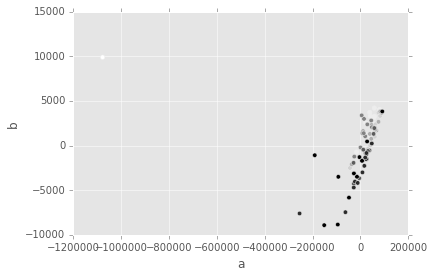

In [47]:
districts_df_e['a'] = districts_reduced[:, 0]
districts_df_e['b'] = districts_reduced[:, 1]

# convert regions to integers, to use them as colors
regions = districts_df.apply(lambda x: x['region'][1], axis='columns').astype(int)

districts_df_e.plot(kind='scatter', x='a', y='b', c=regions)

From the plot we conclude that probably it is beneficial to work with districts.

In [48]:
clients_df.head()

,district_id,gender,birthday
client_id,,,
1,18,Female,1970-12-13
2,1,Male,1945-02-04
3,1,Female,1940-10-09
4,5,Male,1956-12-01
5,5,Female,1960-07-03


In [49]:
clients_districts_df = pd.merge(clients_df, districts_df.drop(['region', 'district_name'], axis='columns'), left_on='district_id', right_index=True, how='left', sort=False)

# we no longer need district_id column
clients_districts_df = clients_districts_df.drop('district_id', axis='columns')

clients_districts_df.head()

,gender,birthday,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
client_id,,,,,,,,,,,,,,,
1,Female,1970-12-13,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
2,Male,1945-02-04,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
3,Female,1940-10-09,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
4,Male,1956-12-01,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
5,Female,1960-07-03,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


Now we'll merge **Credit Cards** and **Clients** information with the accounts.

As there may be multiple credit cards and clients associated with a given account, we have to devise a certain heuristics.

In [50]:
dispositions_df.describe(include='all')

,client_id,account_id,type
count,5369.000000,5369.000000,5369
unique,NaN,NaN,2
top,NaN,NaN,OWNER
freq,NaN,NaN,4500
mean,3359.011920,2767.496927,NaN
std,2832.911984,2307.843630,NaN
min,1.000000,1.000000,NaN
25%,1418.000000,1178.000000,NaN
50%,2839.000000,2349.000000,NaN
75%,4257.000000,3526.000000,NaN


In [51]:
dispositions_df.type.unique()

array(['OWNER', 'DISPONENT'], dtype=object)

To start, we'll simply use the information about the owner of the account.

We'll check the data if there is really only one owner per account.

In [52]:
dispositions_owners_df = dispositions_df[dispositions_df['type'] == 'OWNER'].drop('type', axis='columns')

In [53]:
owners_per_account_df = dispositions_owners_df.groupby(['account_id']).count()

owners_per_account_df[owners_per_account_df['client_id'] != 1].count(axis='index')

client_id    0
dtype: int64

We can now merge **clients** with **accounts**

In [54]:
accounts_disp_merge = accounts_df.merge(dispositions_owners_df, left_index=True, right_on='account_id', how='left', sort=False)
accounts_disp_merge = accounts_disp_merge.set_index('account_id')


accounts_clients_df = accounts_disp_merge.merge(clients_districts_df, left_on='client_id', right_index=True, how='left', sort=False)
accounts_clients_df = accounts_clients_df.drop('client_id', axis='columns')

accounts_clients_df = accounts_clients_df.fillna(0)

accounts_clients_df.head()

,district_id,frequency,date,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,...,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
account_id,,,,,,,,,,,,,,,,,,,,,
576,55,monthly issuance,1993-01-01,26.308708,0.295281,-8.291333,-0.040056,0.000000,0,0,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
3818,74,monthly issuance,1993-01-01,0.000000,0.323475,-4.453223,-0.025151,-5.093869,0,0,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
704,55,monthly issuance,1993-01-01,0.000000,0.308940,-5.117044,-0.029023,0.000000,0,0,...,4,1,6,52.4,8620,1.10,1.25,100,1089,1117
2378,16,monthly issuance,1993-01-01,0.000000,0.289776,-15.964195,-0.024958,0.000000,0,0,...,10,1,8,56.9,8427,1.12,1.54,107,1874,1913
2632,24,monthly issuance,1993-01-02,0.000000,0.319428,-3.274818,-0.031207,-5.166912,0,0,...,6,2,8,80.0,8991,1.39,2.01,128,5198,5273


### Loans

We want to keep a summary of the history of loans related to a given account.

In [55]:
loans_df.describe(include='all')

,account_id,date,amount,duration,payments,status
count,682.000000,682,682.000000,682.000000,682.000000,682
unique,NaN,559,NaN,NaN,NaN,4
top,NaN,1998-07-12 00:00:00,NaN,NaN,NaN,C
freq,NaN,4,NaN,NaN,NaN,403
first,NaN,1993-07-05 00:00:00,NaN,NaN,NaN,NaN
last,NaN,1998-12-08 00:00:00,NaN,NaN,NaN,NaN
mean,5824.162757,NaN,151410.175953,36.492669,4190.664223,NaN
std,3283.512681,NaN,113372.406310,17.075219,2215.830344,NaN
min,2.000000,NaN,4980.000000,12.000000,304.000000,NaN
25%,2967.000000,NaN,66732.000000,24.000000,2477.000000,NaN


In [56]:
print(loans_df.status.unique())

['B' 'A' 'C' 'D']


For reference:
 * **A-** contract finished, no problems
 * **B-** contract finished, loan not payed
 * **C-** running contract, ok so far
 * **D-** running contract, client in debt
 
Lets  see how the loans distribute accross the four categories:

In [57]:
loans_df.groupby('status').count()['account_id']

status
A    203
B     31
C    403
D     45
Name: account_id, dtype: int64

There are also a lot of contracts running, but most importantly there is a gret disparity between the two counts of the different loans results. We must be aware of this when training the algorithms. As we want to identify properly the loans that will have the **B** status, we have to be carefull when structuring the training and testing datasets.

In order to summarize this data, we want to obtain the *count* of loans in each state, as well as the *average* and *standard deviation* of the amount and duration associated with each loan.

In [58]:
def summarize_loans(df):
    summaries_dfs = []
    for tp in df['status'].unique():
        tmp_df = df[df['status'] == tp].drop('status', axis=1)
        
        tmp_grp_df = tmp_df.groupby('account_id').agg([np.count_nonzero, np.average, np.std])
        
        amount_df = tmp_grp_df['amount']
        amount_df = amount_df.rename(columns={'count_nonzero': tp + '_cnt',
                                           'average': tp + '_amount_avg',
                                           'std': tp + '_amount_std',
                                          })
        
        duration_df = tmp_grp_df['duration']
        duration_df = duration_df.drop('count_nonzero', axis='columns')
        duration_df = duration_df.rename(columns={'average': tp + '_duration_avg',
                                                  'std': tp + '_duration_std',
                                                 })
        joined_summary_df = amount_df.join(duration_df)
        summaries_dfs.append(joined_summary_df)
    
    # now concatenate the summaries_dfs
    summaries_df = pd.concat(summaries_dfs, axis='columns')
    return summaries_df


loans_summary_df = summarize_loans(loans_df)
loans_summary_df = loans_summary_df.fillna(0)
loans_summary_df.head()

,B_cnt,B_amount_avg,B_amount_std,B_duration_avg,B_duration_std,A_cnt,A_amount_avg,A_amount_std,A_duration_avg,A_duration_std,C_cnt,C_amount_avg,C_amount_std,C_duration_avg,C_duration_std,D_cnt,D_amount_avg,D_amount_std,D_duration_avg,D_duration_std
account_id,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,1,80952,0,24,0,0,0,0,0,0,0,0,0,0,0
19,1,30276,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,1,30276,0,12,0,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,318480,0,60,0
38,0,0,0,0,0,0,0,0,0,0,1,110736,0,48,0,0,0,0,0,0


And now merge with accounts:

In [59]:
accounts_loans_df = accounts_clients_df.join(loans_summary_df)
accounts_loans_df = accounts_loans_df.fillna(0)
accounts_loans_df.head()

,district_id,frequency,date,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,...,C_cnt,C_amount_avg,C_amount_std,C_duration_avg,C_duration_std,D_cnt,D_amount_avg,D_amount_std,D_duration_avg,D_duration_std
account_id,,,,,,,,,,,,,,,,,,,,,
576,55,monthly issuance,1993-01-01,26.308708,0.295281,-8.291333,-0.040056,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3818,74,monthly issuance,1993-01-01,0.000000,0.323475,-4.453223,-0.025151,-5.093869,0,0,...,0,0,0,0,0,0,0,0,0,0
704,55,monthly issuance,1993-01-01,0.000000,0.308940,-5.117044,-0.029023,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
2378,16,monthly issuance,1993-01-01,0.000000,0.289776,-15.964195,-0.024958,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
2632,24,monthly issuance,1993-01-02,0.000000,0.319428,-3.274818,-0.031207,-5.166912,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
accounts_loans_df.dtypes

district_id                                           int64
frequency                                            object
date                                         datetime64[ns]
pension                                             float64
interest credited                                   float64
household                                           float64
statement                                           float64
insurance payment                                   float64
sanction for negative balance                       float64
loan payment                                        float64
credit_cnt                                          float64
credit_avg                                          float64
credit_std                                          float64
credit_dates_avg                                    float64
credit_dates_std                                    float64
withdrawal_cnt                                      float64
withdrawal_avg                          

We've gathered 55 features to characterize each account, gathering information about the accounts, users (and respective credit cards), transactions and history of loans.

## 3. Predictive Data Mining

The above-mentioned accounts-indexed dataframe, combined with the specification of each loan (duration and amount), constitutes all the needed information to train our algorithms.


Firstly we have to prepare a dataframe such that the machine-learning algorithms are able to undertand it. In order to accomplish that, we will merge this **accounts_loans_df** dataframe with the original **loans_df** dataframe. For new loans that arive, the process will be the same, therefore we want to encapsulate the process in a function:

In [74]:
accounts_final_df = accounts_loans_df.rename(columns={'date': 'date created'})
#accounts_final_df = accounts_clients_df.rename(columns={'date': 'date created'})
accounts_final_df['account_id'] = accounts_final_df.index

def join_loans_accounts(l_df):
    dataset = pd.merge(l_df, accounts_final_df, left_on='account_id', right_index=True, how='left', sort=False)
    #dataset = dataset.drop('account_id', axis='columns')
    return dataset

dataset = join_loans_accounts(loans_df)

In [75]:
accounts_final_df.head()

,district_id,frequency,date created,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,...,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96,account_id
account_id,,,,,,,,,,,,,,,,,,,,,
576,55,monthly issuance,1993-01-01,26.308708,0.295281,-8.291333,-0.040056,0.000000,0,0,...,1,1,100.0,10673,4.75,5.44,100,18782,18347,576
3818,74,monthly issuance,1993-01-01,0.000000,0.323475,-4.453223,-0.025151,-5.093869,0,0,...,1,1,100.0,12541,0.29,0.43,167,85677,99107,3818
704,55,monthly issuance,1993-01-01,0.000000,0.308940,-5.117044,-0.029023,0.000000,0,0,...,1,6,52.4,8620,1.10,1.25,100,1089,1117,704
2378,16,monthly issuance,1993-01-01,0.000000,0.289776,-15.964195,-0.024958,0.000000,0,0,...,1,8,56.9,8427,1.12,1.54,107,1874,1913,2378
2632,24,monthly issuance,1993-01-02,0.000000,0.319428,-3.274818,-0.031207,-5.166912,0,0,...,2,8,80.0,8991,1.39,2.01,128,5198,5273,2632


Now we have to extract the useful rows: the ones with **status** *A* and *B*:

In [76]:
def select_useful_rows(df):
    mask = (dataset.status == 'A') | (dataset.status == 'B')
    return dataset[mask]

In [77]:
dataset_useful = select_useful_rows(dataset)

In [78]:
print(dataset.shape)
print(dataset_useful.shape)

(682, 42)
(234, 42)


We just have now to convert the timestamp columns to an integer value. We'll use Unix time:

In [79]:
def convert_date_cols(df):
    new_df = df.copy()
    for col in new_df.columns:
        if new_df[col].dtype == 'datetime64[ns]':
            new_df[col] = new_df[col].astype(np.int64) // 10**9
    return new_df
            

dataset_valid = convert_date_cols(dataset_useful)

and convert categorical data in new columns:

In [80]:
features_mask = dataset_valid.columns[dataset_valid.columns != 'status']

dataset_valid_num = pd.get_dummies(dataset_valid[features_mask])
dataset_valid_num['status'] = dataset_valid['status']

### Decision tree

We'll start off by using a decision tree as our first machine learning algorithm. It has the benefits of working both with continuous and discrete data types, and provides a very natural way to interpret the results it gives.

In [85]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

features_mask = dataset_valid_num.columns[dataset_valid_num.columns != 'status']
features = dataset_valid_num[features_mask]
label_mask = 'status'
label = dataset_valid_num[label_mask]

decision_tree_classifier = DecisionTreeClassifier(random_state=0)

decision_tree_classifier = decision_tree_classifier.fit(features, label)

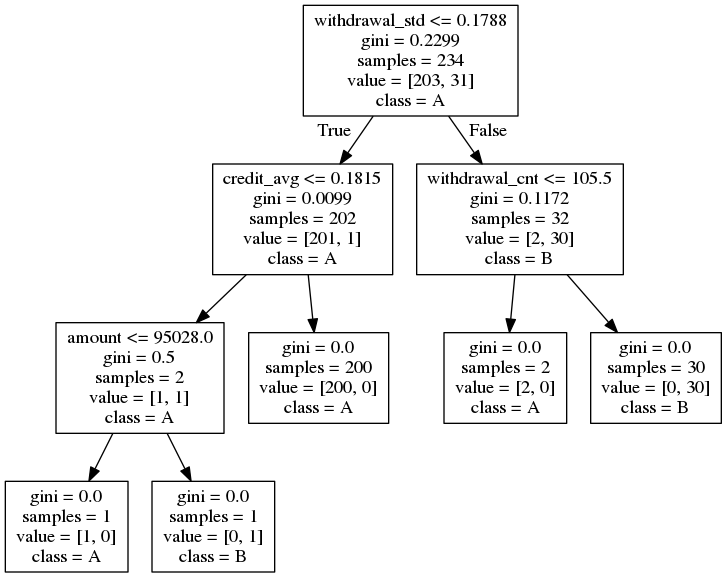

In [87]:
from sklearn.externals.six import StringIO
import pydot_ng as pydot
from IPython.display import Image

dot_data = StringIO()  
tree.export_graphviz(decision_tree_classifier, out_file=dot_data,  
                     feature_names=features_mask,  
                     class_names=['A', 'B'],  
                     #filled=True, 
                     #rounded=True,  
                     #special_characters=True
                    )  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  